# Detección de probabilidad de impagos

<img src='https://image.cnbcfm.com/api/v1/image/106210419-1572366832669gettyimages-1137376687.jpg?v=1572366860&w=1340&h=500'>

Vamos a construir un modelo de Machine Learning que prediga la probabilidad de que un cliente sufra dificultades financieras en el futuro. 

Concretamente, el dataset con el que vamos a trabajar contempla dificultades financieras a dos años vista, por lo que nuestras predicciones serán para este rango temporal.

Los datos pertenecen a una [competición de Kaggle propuesta por la escuela The Bridge.]('https://www.kaggle.com/c/gmsc-thebridge-dsft2109/leaderboard')

## Configuración del Notebook

Vamos a configurar las visualizaciones y a importar algunas librerías que utilizaremos.

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# Establecemos una medida estándar para los gráficos de Seaborn
sns.set(rc={'figure.figsize':(14,10)})

## 1. Análisis Exploratorio de Datos

Vamos a cargar nuestros datasets, que están disponibles en la sección [data]('https://www.kaggle.com/c/gmsc-thebridge-dsft2109/data') de la competición.

Concretamente, tenemos dos datasets, uno de entrenamiento y otro de validación.

In [2]:
# Cargando los datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Indices de los datos de validación que utilizaremos en la submission
indices = list(test['Id'])

In [4]:
# Valores Nulos - Datos de entrenamiento
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104805 entries, 0 to 104804
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Id                                    104805 non-null  int64  
 1   SeriousDlqin2yrs                      104805 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  104805 non-null  float64
 3   age                                   104805 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  104805 non-null  int64  
 5   DebtRatio                             104805 non-null  float64
 6   MonthlyIncome                         84024 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       104805 non-null  int64  
 8   NumberOfTimes90DaysLate               104805 non-null  int64  
 9   NumberRealEstateLoansOrLines          104805 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  104805 non-null  int64  
 11  

In [5]:
# Valores Nulos - Datos de validación
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45195 entries, 0 to 45194
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Id                                    45195 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  45195 non-null  float64
 2   age                                   45195 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  45195 non-null  int64  
 4   DebtRatio                             45195 non-null  float64
 5   MonthlyIncome                         36245 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       45195 non-null  int64  
 7   NumberOfTimes90DaysLate               45195 non-null  int64  
 8   NumberRealEstateLoansOrLines          45195 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  45195 non-null  int64  
 10  NumberOfDependents                    44020 non-null  float64
dtypes: float64(4), 

### 1.1. Variable `RevolvingUtilizationOfUnsecuredLines`

Esta variable es el porcentaje de [utilización de créditos *Revolving*]('https://es.wikipedia.org/wiki/Cuenta_de_cr%C3%A9dito_renovable') del cliente. Se considera que un puntaje de 30% o menor indica salud financiera, mientras que un porcentaje mayor al 30% indica problemas financieros a medio plazo.

In [6]:
# Los valores superiores a 2 son valores muy extraños
list_modif = list(test[test.RevolvingUtilizationOfUnsecuredLines > 2].index)
sin_extranos = test.drop(list_modif, axis=0)

In [7]:
# No queremos eliminar filas de los datos de validación, por lo que calculamos el porcentaje en función de los ingresos del cliente

# Ingresos superiores a $6000 (datos brutos)
sin_extranos[sin_extranos.MonthlyIncome >= 6000]['RevolvingUtilizationOfUnsecuredLines'].mean()

0.28938222888449755

In [8]:
# Ingresos inferiores a $6000 (datos brutos)
sin_extranos[sin_extranos.MonthlyIncome < 6000]['RevolvingUtilizationOfUnsecuredLines'].mean()

0.3658520082805337

In [9]:
# Guardamos los índices para modificarlos (datos de validación)
test_lista_indices_mas_6000 = test[(test.RevolvingUtilizationOfUnsecuredLines > 2) & (test.MonthlyIncome >= 6000)].index
test_lista_indices_menos_6000 = test[(test.RevolvingUtilizationOfUnsecuredLines > 2) & ((test.MonthlyIncome < 6000) | (test.MonthlyIncome.isnull()))].index

In [10]:
# En los datos de entrenamiento, directamente eliminamos valores superiores a 2 para evitar ruido en nuestro modelo

# Eliminando valores mayores a 2 (datos de entrenamiento)
train = train.drop(list(train[train.RevolvingUtilizationOfUnsecuredLines > 2].index))

# Modificando valores mayores a 2 en los datos de validación por el valor medio
test.loc[test_lista_indices_mas_6000, 'RevolvingUtilizationOfUnsecuredLines'] = 0.289
test.loc[test_lista_indices_menos_6000, 'RevolvingUtilizationOfUnsecuredLines'] = 0.365

In [11]:
# Ahora las medias deben ser similares en ambos datasets
print(f'- Media utilización créditos Revolving (datos de entrenamiento): {train.RevolvingUtilizationOfUnsecuredLines.mean()}')
print(f'- Media utilización créditos Revolving (datos de entrenamiento): {test.RevolvingUtilizationOfUnsecuredLines.mean()}')

- Media utilización créditos Revolving (datos de entrenamiento): 0.320210753899275
- Media utilización créditos Revolving (datos de entrenamiento): 0.3206656274097356


### Distribución de utilización de créditos *Revolving* - Clientes con problemas financieros

In [12]:
# Mediana de 'RevolvingUtilizationOfUnsecuredLines' - Clientes con problemas financieros
revolv_mediana_problemas_financ = train[train.SeriousDlqin2yrs == 1]['RevolvingUtilizationOfUnsecuredLines'].median()
revolv_mediana_problemas_financ

0.830633873

In [13]:
train[(train.SeriousDlqin2yrs == 1)]['RevolvingUtilizationOfUnsecuredLines']

11        0.964673
17        0.025656
20        0.392248
40        0.728150
64        0.734478
            ...   
104774    1.000000
104775    1.135552
104781    0.920107
104785    0.983825
104793    0.224711
Name: RevolvingUtilizationOfUnsecuredLines, Length: 6913, dtype: float64

In [14]:
sns.set_style('whitegrid')

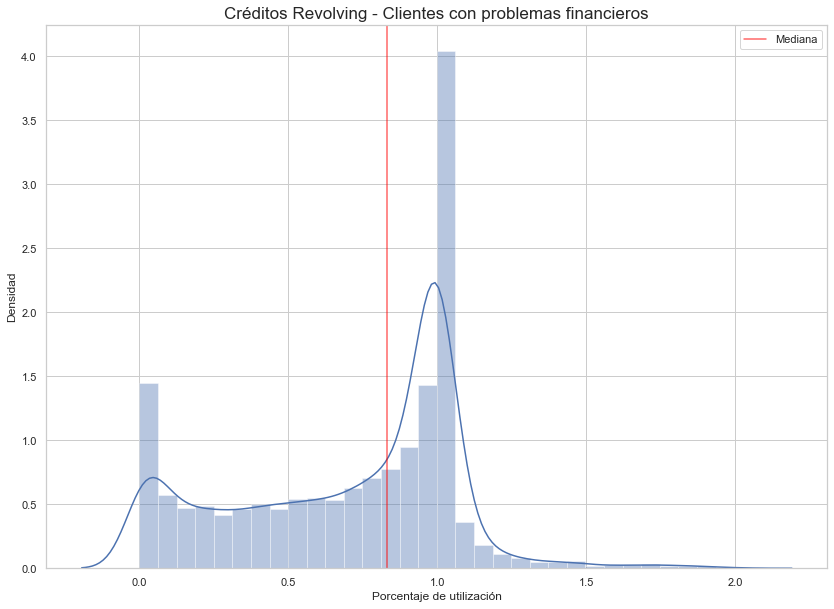

In [15]:
sns.distplot(train[(train.SeriousDlqin2yrs == 1)]['RevolvingUtilizationOfUnsecuredLines'])
plt.title('Créditos Revolving - Clientes con problemas financieros', fontsize=17)
plt.axvline(revolv_mediana_problemas_financ, color='red', alpha=0.6, label='Mediana')
plt.xlabel('Porcentaje de utilización')
plt.ylabel('Densidad')
plt.legend();

### Distribución de utilización de créditos *Revolving* - Clientes sin problemas financieros

In [16]:
# Mediana de 'RevolvingUtilizationOfUnsecuredLines' - Clientes con problemas financieros
revolv_mediana_sin_problemas_financ = train[train.SeriousDlqin2yrs == 0]['RevolvingUtilizationOfUnsecuredLines'].median()
revolv_mediana_sin_problemas_financ

0.132447567

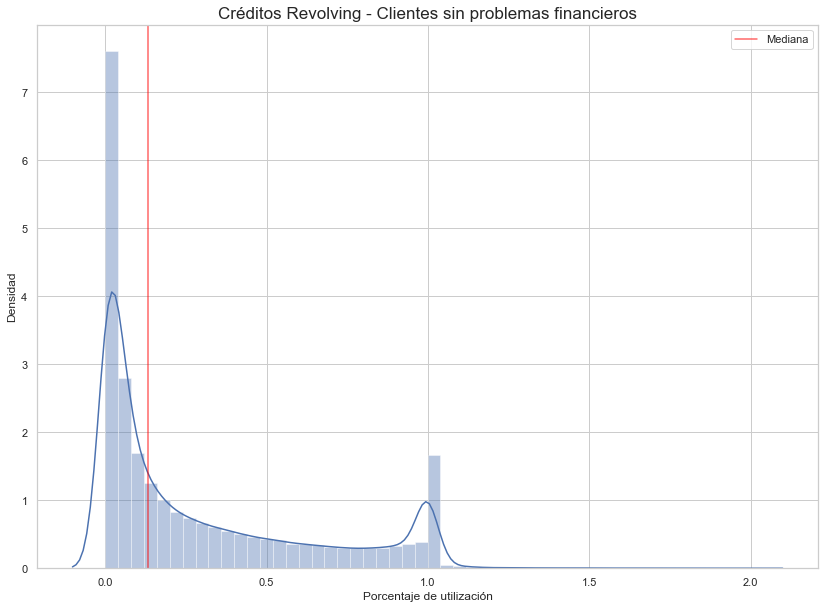

In [17]:
sns.distplot(train[(train.SeriousDlqin2yrs == 0)]['RevolvingUtilizationOfUnsecuredLines'])
plt.title('Créditos Revolving - Clientes sin problemas financieros', fontsize=17)
plt.axvline(revolv_mediana_sin_problemas_financ, color='red', alpha=0.6, label='Mediana')
plt.xlabel('Porcentaje de utilización')
plt.ylabel('Densidad')
plt.legend();

### 1.2. Variable `MonthlyIncome`
Esta variable representa los ingresos mensuales del cliente. Tenemos gran cantidad de valores nulos, por lo que debemos modificarlos de alguna manera, ya que consideramos que los ingresos mensuales de los clientes son una variable crítica para saber si existirán problemas financieros en el futuro.

In [18]:
# Tomamos como referencia el 30% de utilización de créditos Revolving 

# Ingresos medianos de clientes según la tasa de uso de créditos Revolving
print(f"- Ingresos medianos mensuales de clientes con menos de un 30% de tasa de créditos Revolving: {train[train.RevolvingUtilizationOfUnsecuredLines < .3]['MonthlyIncome'].median()}")
print(f"- Ingresos medianos mensuales de clientes con más de un 30% de tasa de créditos Revolving: {train[train.RevolvingUtilizationOfUnsecuredLines >= .3]['MonthlyIncome'].median()}")

- Ingresos medianos mensuales de clientes con menos de un 30% de tasa de créditos Revolving: 5666.0
- Ingresos medianos mensuales de clientes con más de un 30% de tasa de créditos Revolving: 5000.0


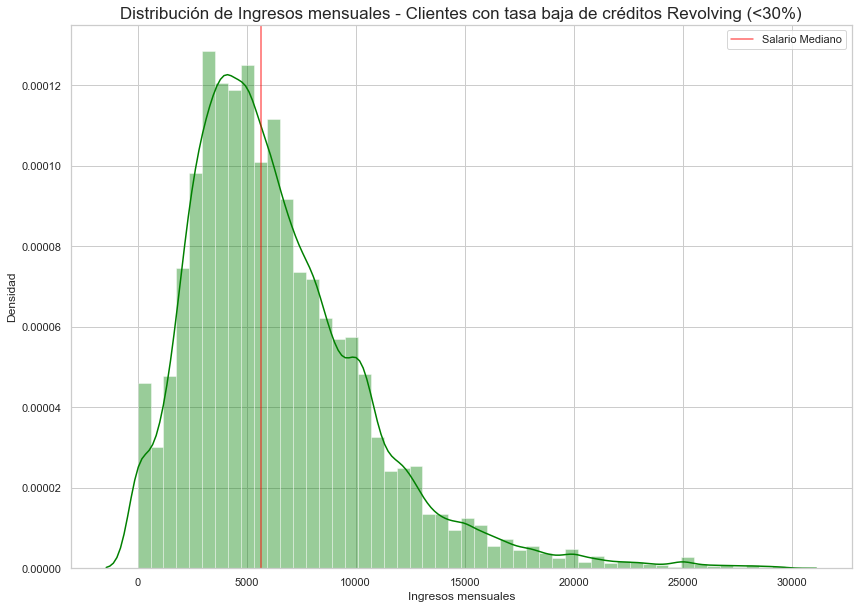

In [19]:
median_income_low_revolv = train[train.RevolvingUtilizationOfUnsecuredLines < .3]['MonthlyIncome'].median()
sns.distplot(train[(train.MonthlyIncome < 30000) & (train.RevolvingUtilizationOfUnsecuredLines < .3)]['MonthlyIncome'], color='green')
plt.title('Distribución de Ingresos mensuales - Clientes con tasa baja de créditos Revolving (<30%)', fontsize=17)
plt.axvline(median_income_low_revolv, color='red', alpha=0.6, label='Salario Mediano')
plt.xlabel('Ingresos mensuales')
plt.ylabel('Densidad')
plt.legend();

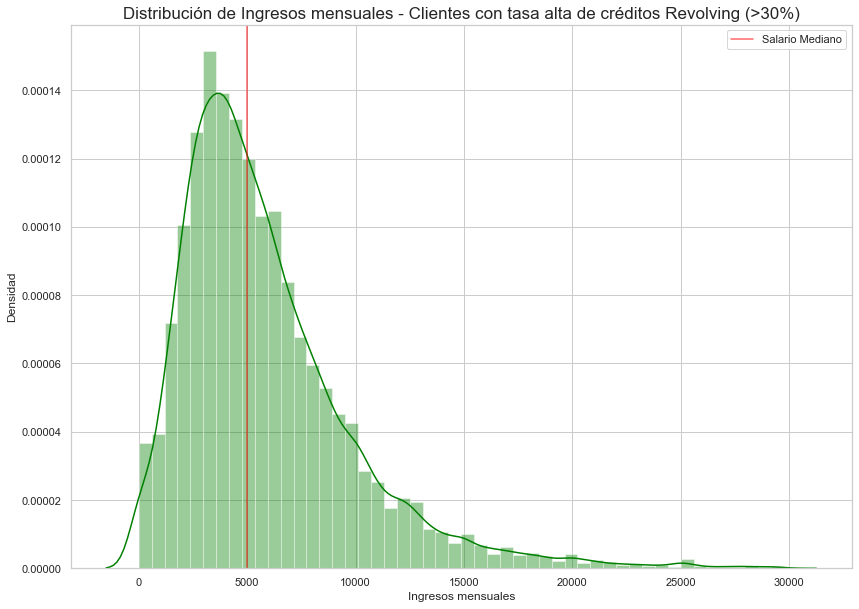

In [20]:
median_income_high_revolv = train[train.RevolvingUtilizationOfUnsecuredLines >= .3]['MonthlyIncome'].median()
sns.distplot(train[(train.MonthlyIncome < 30000) & (train.RevolvingUtilizationOfUnsecuredLines >= .3)]['MonthlyIncome'], color='green')
plt.title('Distribución de Ingresos mensuales - Clientes con tasa alta de créditos Revolving (>30%)', fontsize=17)
plt.axvline(median_income_high_revolv, color='red', alpha=0.6, label='Salario Mediano')
plt.xlabel('Ingresos mensuales')
plt.ylabel('Densidad')
plt.legend();

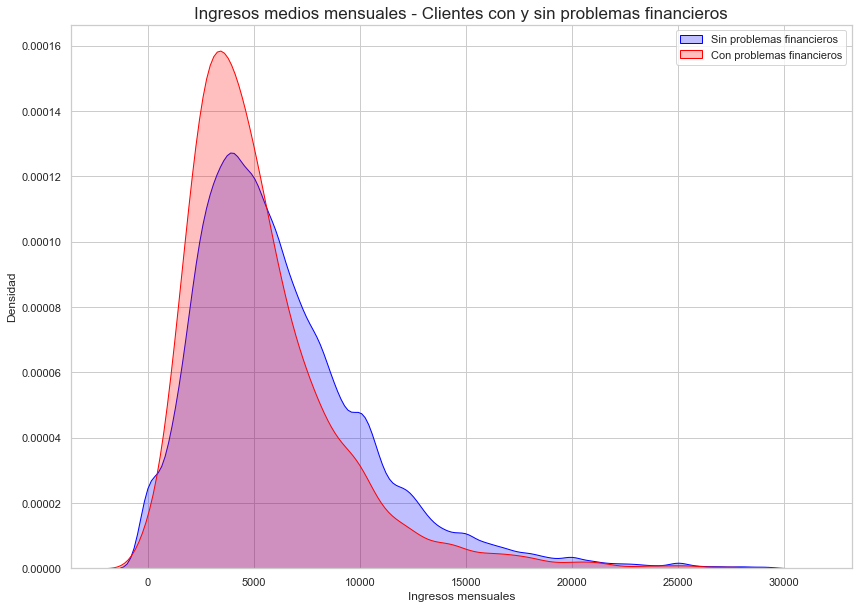

In [21]:
median_income_low_revolv = train[train.RevolvingUtilizationOfUnsecuredLines < .3]['MonthlyIncome'].median()
sns.kdeplot(train[(train.SeriousDlqin2yrs == 0) & (train.MonthlyIncome < 30000)]['MonthlyIncome'], color='blue', shade=True, label='Sin problemas financieros')
sns.kdeplot(train[(train.SeriousDlqin2yrs == 1) & (train.MonthlyIncome < 30000)]['MonthlyIncome'], color='red', shade=True, label='Con problemas financieros')
plt.title('Ingresos medios mensuales - Clientes con y sin problemas financieros', fontsize=17)
plt.xlabel('Ingresos mensuales')
plt.ylabel('Densidad')
plt.legend();

La distribución de ingresos es más baja en los clientes con problemas financieros y con alta tasa de utilización de créditos Revolving.

In [22]:
# Guardamos los índices de los clientes con valores nulos en 'MonthlyIncome', separados por el umbral de uso de créditos Revolving (30%)

# Datos de entrenamiento
indices_monthly_null_low_revolving = list(train[(train.RevolvingUtilizationOfUnsecuredLines < .3) & (train.MonthlyIncome.isnull())].index)
indices_monthly_null_high_revolving = list(train[(train.RevolvingUtilizationOfUnsecuredLines >= .3) & (train.MonthlyIncome.isnull())].index)

# Datos de validación
indices_monthly_null_low_revolving_test = list(test[(test.RevolvingUtilizationOfUnsecuredLines < .3) & (test.MonthlyIncome.isnull())].index)
indices_monthly_null_high_revolving_test = list(test[(test.RevolvingUtilizationOfUnsecuredLines >= .3) & (test.MonthlyIncome.isnull())].index)

In [23]:
# Sustituimos por los salarios medianos en ambos datasets

# Datos de entrenamiento
train.loc[indices_monthly_null_low_revolving, 'MonthlyIncome'] = median_income_low_revolv
train.loc[indices_monthly_null_high_revolving, 'MonthlyIncome'] = median_income_high_revolv

# Datos de validación
test.loc[indices_monthly_null_low_revolving_test, 'MonthlyIncome'] = median_income_low_revolv
test.loc[indices_monthly_null_high_revolving_test, 'MonthlyIncome'] = median_income_high_revolv

In [24]:
# Ahora las medias deberían ser similares
print(train['MonthlyIncome'].mean())
print(test['MonthlyIncome'].mean())

6441.369206786404
6405.019913707269


### 1.3. Variable `NumberOfDependents`
Como tenemos pocos valores nulos —relativamente— simplemente vamos a rellenarlos con el valor más común en ambos datasets.

In [25]:
# Número medio de dependientes en cada dataset
print(train['NumberOfDependents'].mean())
print(test['NumberOfDependents'].mean())

0.7560817513086692
0.7599045888232622


In [26]:
# Rellenamos los valores nulos en esta columna con 1

# Datos de entrenamiento
ind_dep_null_train = list(train[train.NumberOfDependents.isnull()].index)
# Datos de validación
ind_dep_null_test = list(test[test.NumberOfDependents.isnull()].index)

# Rellenamos los valores nulos
train.loc[ind_dep_null_train, 'NumberOfDependents'] = 1
test.loc[ind_dep_null_test, 'NumberOfDependents'] = 1

### Descarte de la columna `Id`
La columna `Id` solo aporta ruido a nuestro modelo y la podemos eliminar.

In [27]:
# Descartamos la columna 'Id' en ambos DataFrames
train  = train.drop(['Id'], axis=1)
test  = test.drop(['Id'], axis=1)

### 1.4. Correlaciones
Vamos a ver un mapa de calor de correlaciones de los datos de entrenamiento, para comprobar si existe correlación entre algún predictor y el target.

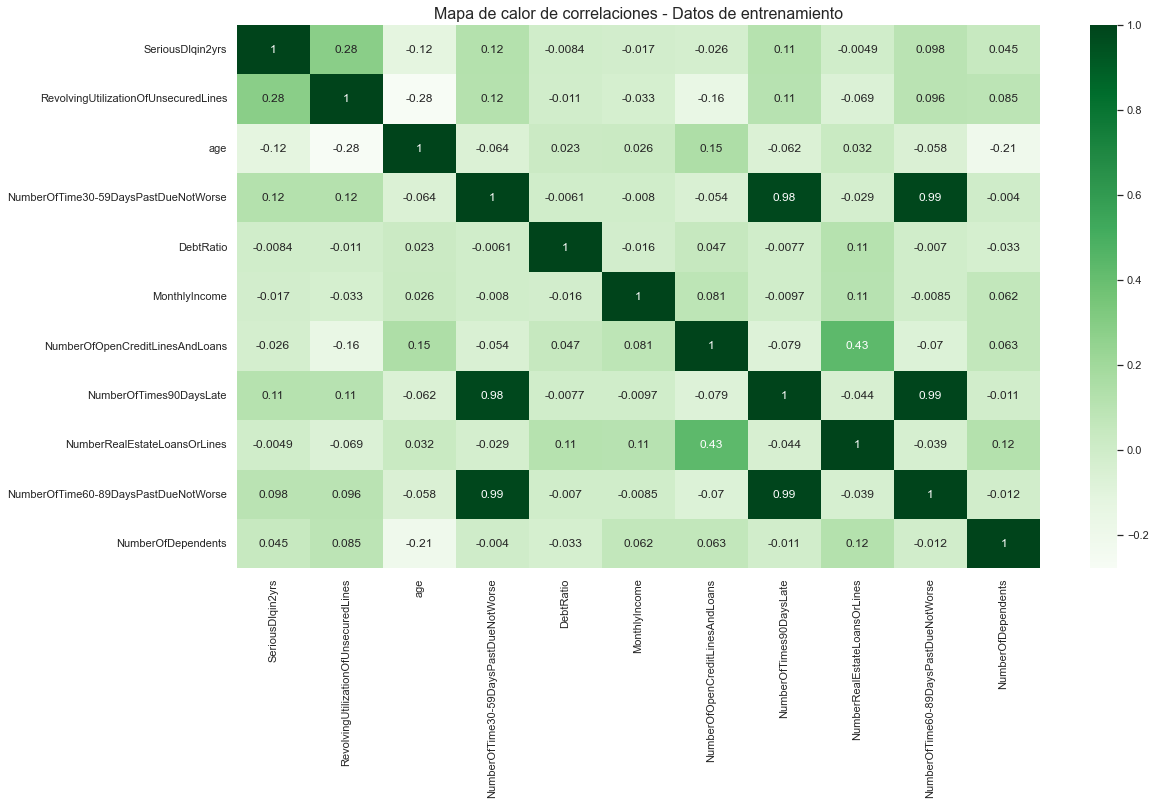

In [28]:
# Correlaciones - Datos de entrenamiento
plt.figure(figsize=(18,10))
sns.heatmap(train.corr(), annot=True, cmap='Greens')
plt.title('Mapa de calor de correlaciones - Datos de entrenamiento', fontsize=16);

## 2. Preprocesamiento de Datos

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Creamos una copia de nuestros datos para poder re-manipularlos en caso de ser necesario
train_copy = train.copy()
test_copy = test.copy()

# Target y features
X = train_copy.drop(['SeriousDlqin2yrs'], axis=1)
y = train_copy['SeriousDlqin2yrs']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Scaling the data
scaler = StandardScaler()

# Data scaled
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_copy = scaler.transform(test_copy)

## 3. Algoritmos de Machine Learning

In [30]:
from sklearn import metrics

# En este diccionario iremos almacenando los scores de cada modelo
performance = {}

# Función para obtener el ROC AUC Score de un modelo
def roc_auc(modelo):
    '''Recibe un modelo, lo entrena con datos de entrenamiento, 
    realiza predicciones con datos de validación y devuelve el 
    ROC AUC Score y una gráfica con la curva ROC.
    '''
    # Entrenamos el modelo con datos de entrenamiento
    modelo.fit(X_train, y_train)
    # Predicciones con datos de validación
    preds = modelo.predict_proba(X_test)
    # Gráfico de la curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    display.plot()
    plt.show()
    # ROC AUC Score de las predicciones
    print(f'ROC AUC Score {modelo.__class__.__name__} :', metrics.roc_auc_score(y_test, preds[:, 1]))
    # Agregamos el Score al diccionario
    performance[modelo.__class__.__name__] = metrics.roc_auc_score(y_test, preds[:, 1])

### 1. XGBClassifier

[18:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


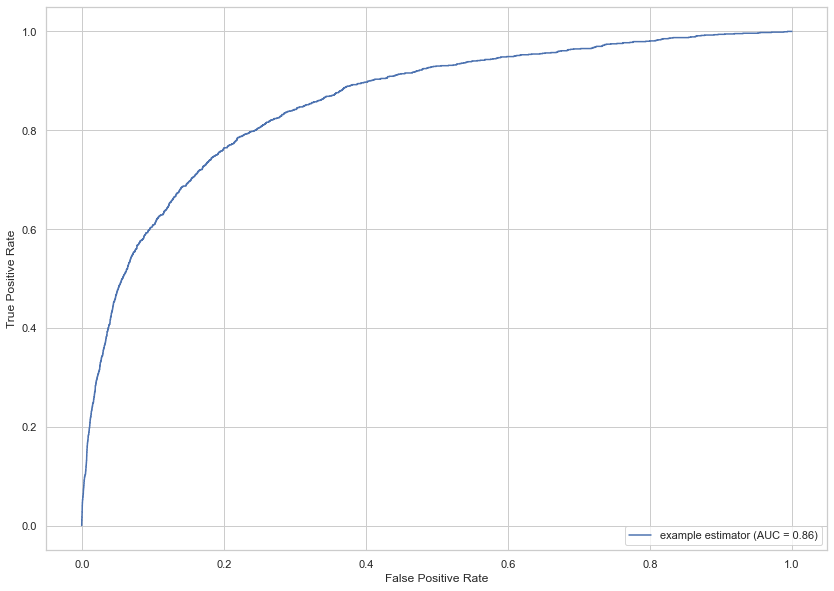

ROC AUC Score XGBClassifier : 0.8559702827317669


In [31]:
from xgboost import XGBClassifier
from sklearn import metrics

# Modelo 1 - XGBClassifier
xgb_classifier = XGBClassifier(
    max_depth=6, 
    learning_rate=0.08)

# ROC Curve y ROC AUC Score
roc_auc(xgb_classifier)

### 2. XGBRFClassifier

[18:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


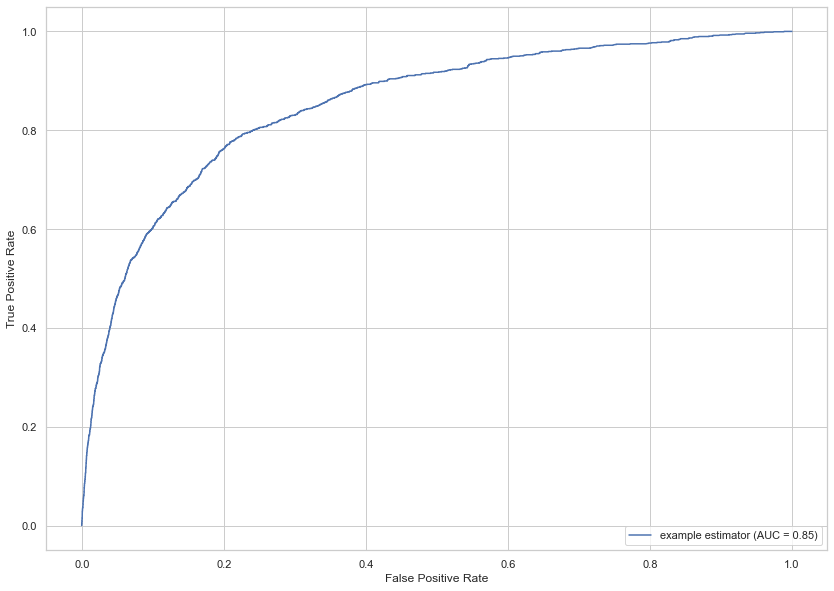

ROC AUC Score XGBRFClassifier : 0.851556558617023


In [32]:
from xgboost import XGBRFClassifier

# Modelo 2 - XGBRFClassifier
xgb_rf_classifier = XGBRFClassifier(
    objective='binary:logistic', 
    learning_rate=0.02,
    max_depth=10,
    n_estimators=200)

# ROC Curve y ROC AUC Score
roc_auc(xgb_rf_classifier)

### 3. AdaBoost

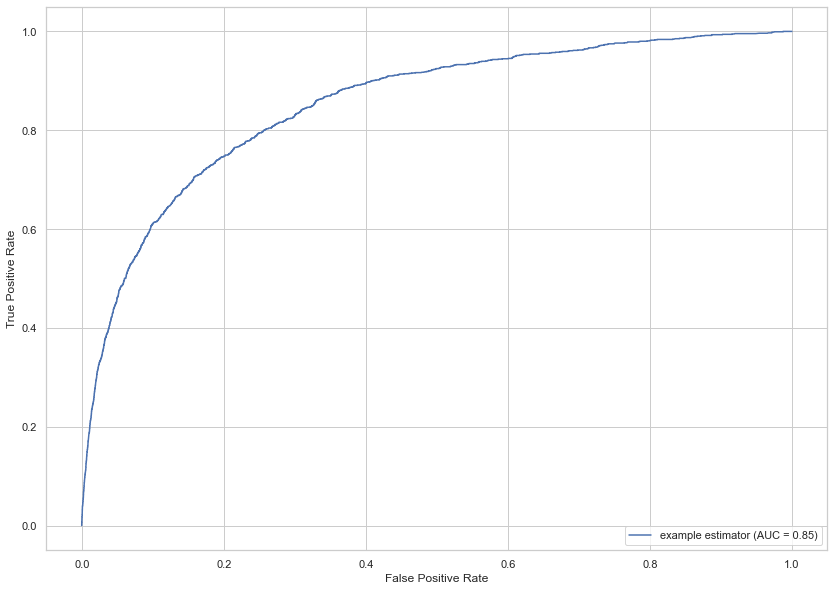

ROC AUC Score AdaBoostClassifier : 0.852415353481687


In [33]:
from sklearn.ensemble import AdaBoostClassifier

# Modelo 3 - AdaBoostClassifier
ada = AdaBoostClassifier(
    n_estimators=400, 
    learning_rate=0.1)

# ROC Curve y ROC AUC Score
roc_auc(ada)

### 4. CatBoost

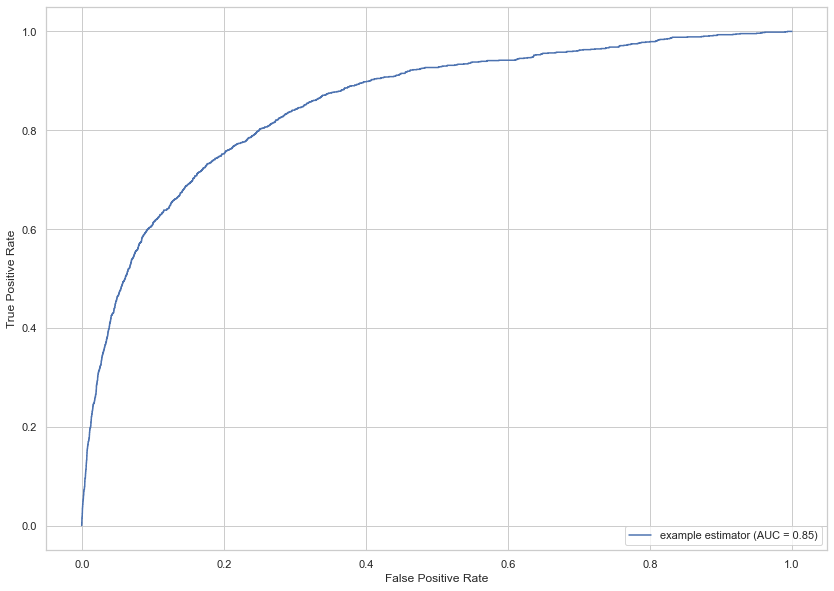

ROC AUC Score CatBoostClassifier : 0.8533402588346366


In [34]:
from catboost import CatBoostClassifier

# Modelo 4 - CatBoostClassifier
cbc = CatBoostClassifier(silent=True)

# ROC Curve y ROC AUC Score
roc_auc(cbc)

### 5. Red Neuronal 

Epoch 1/200
164/164 [==============================] - 5s 23ms/step - loss: 0.3745 - auc: 0.6803 - val_loss: 0.2183 - val_auc: 0.7746
Epoch 2/200
164/164 [==============================] - 3s 21ms/step - loss: 0.2208 - auc: 0.7794 - val_loss: 0.2091 - val_auc: 0.8234
Epoch 3/200
164/164 [==============================] - 3s 21ms/step - loss: 0.2100 - auc: 0.8016 - val_loss: 0.1947 - val_auc: 0.8311
Epoch 4/200
164/164 [==============================] - 3s 21ms/step - loss: 0.2059 - auc: 0.8163 - val_loss: 0.1873 - val_auc: 0.8398
Epoch 5/200
164/164 [==============================] - 3s 21ms/step - loss: 0.1998 - auc: 0.8287 - val_loss: 0.1882 - val_auc: 0.8472
Epoch 6/200
164/164 [==============================] - 3s 21ms/step - loss: 0.1970 - auc: 0.8325 - val_loss: 0.1860 - val_auc: 0.8433
Epoch 7/200
164/164 [==============================] - 4s 22ms/step - loss: 0.1931 - auc: 0.8383 - val_loss: 0.1853 - val_auc: 0.8372
Epoch 8/200
164/164 [==============================] - 4s 23ms

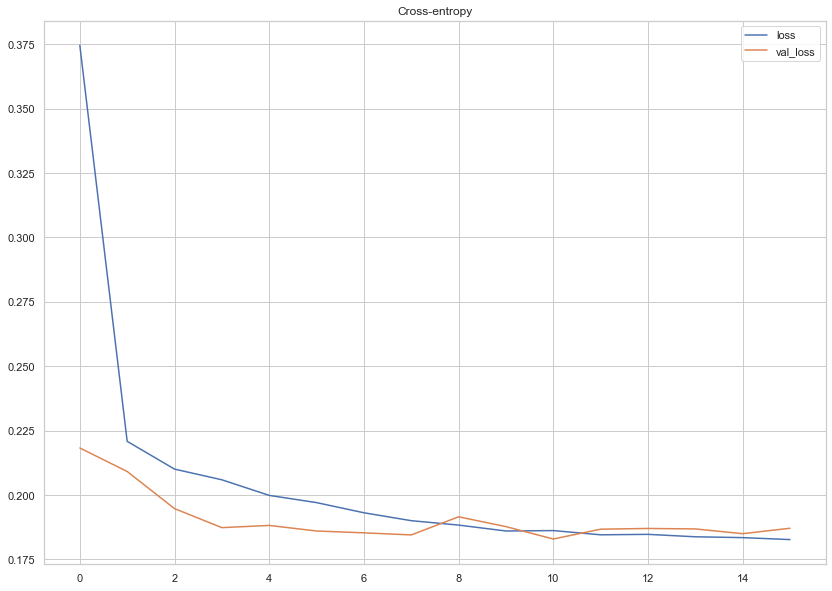

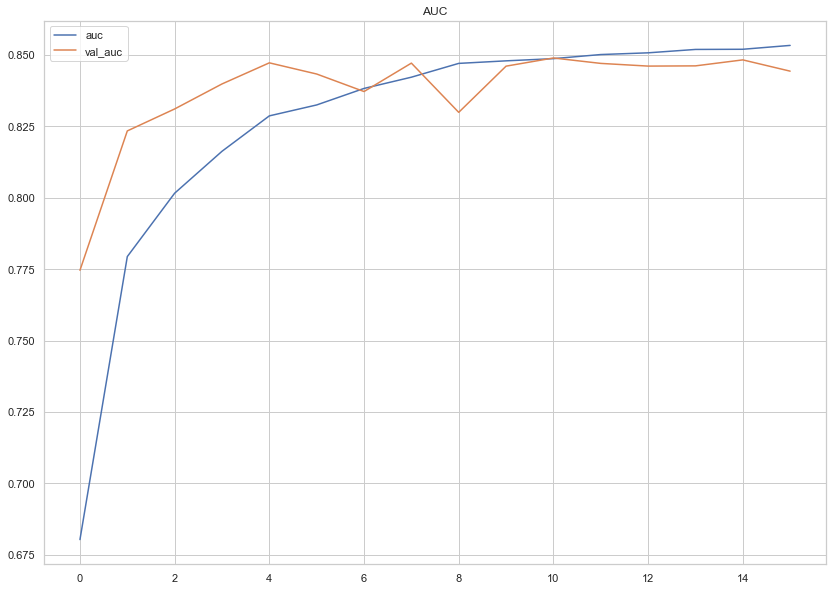

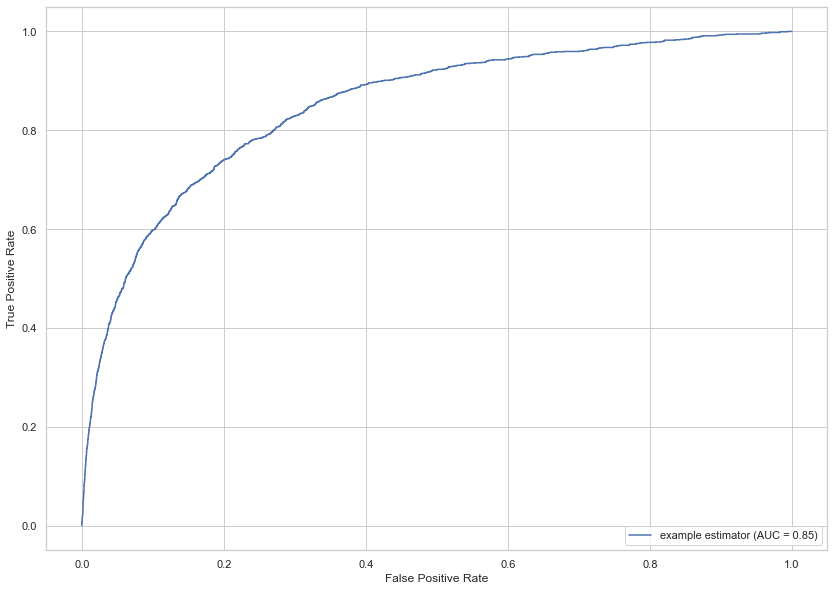

In [35]:
input_shape = [X_train.shape[1]]

from tensorflow import keras
from tensorflow.keras import layers

# Red Neuronal
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='elu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.4), 
    layers.Dense(512, activation='elu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='elu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Optimizador, Función de Pérdida y Métrica
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[keras.metrics.AUC()]
)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# Entrenando la Red
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

# Resultados
history_df = pd.DataFrame(history.history)
history_df.iloc[:, [0, 2]].plot(title="Cross-entropy")
history_df.iloc[:, [1, 3]].plot(title="AUC")

preds = model.predict_proba(X_test)

performance['Red Neuronal'] = metrics.roc_auc_score(y_test, preds.ravel())

# Mostrando la ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

In [36]:
# Creamos un Pandas DataFrame a partir de los scores obtenidos por cada modelo
scores_df = pd.DataFrame(performance, index=['ROC AUC Score']).T.sort_values('ROC AUC Score', ascending=False)
scores_df

,ROC AUC Score
XGBClassifier,0.855970
CatBoostClassifier,0.853340
AdaBoostClassifier,0.852415
XGBRFClassifier,0.851557
Red Neuronal,0.848768


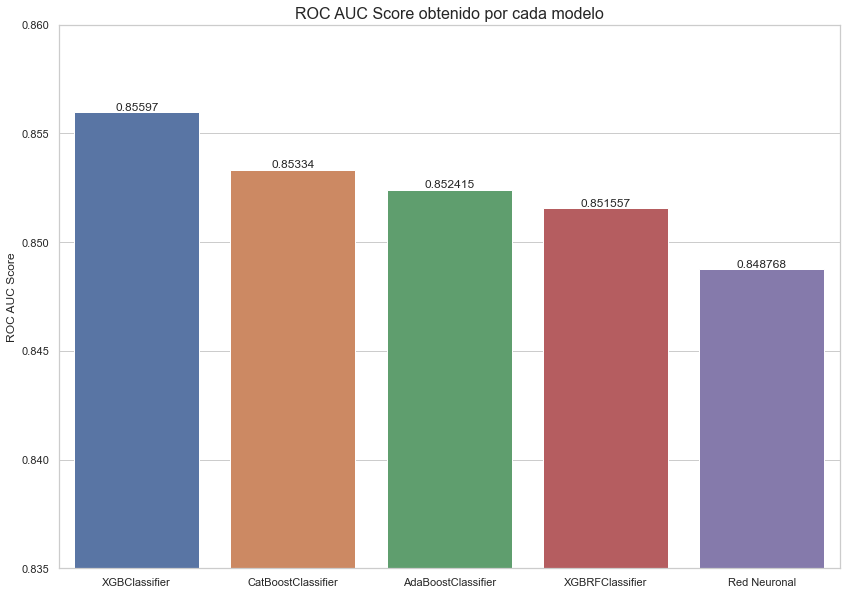

In [37]:
# Visualizamos los scores de los distintos modelos
ax = sns.barplot(x=scores_df.index, y='ROC AUC Score', data=scores_df)
ax.bar_label(ax.containers[0])
plt.ylim(0.835, 0.86)
plt.title('ROC AUC Score obtenido por cada modelo', fontsize=16);

**El modelo con mejor ROC AUC Score ha sido XGBClassifier.**

## 4. Resultados

In [38]:
# Predicciones Finales
final_preds = xgb_classifier.predict_proba(test)

In [39]:
# Submission a Kaggle
submission = pd.DataFrame(
    {'Id': indices,
    'SeriousDlqin2yrs': final_preds[:, 1]}
)

submission.to_csv('submissions/submission.csv', index=False)

submission

,Id,SeriousDlqin2yrs
0,0,0.277876
1,9,0.089715
2,17,0.063576
3,18,0.074740
4,24,0.060921
...,...,...
45190,149992,0.114995
45191,149994,0.068476
45192,149995,0.058849
45193,149996,0.050960


## 5. Score en Kaggle
Hemos obtenido un Score de 0.84 en la competición de Kaggle.